Source: https://web.physics.utah.edu/~bolton/python_lens_demo/

In [18]:
#
# lensdemo_funcs.py
#
# Function module for strong lensing demos
#
# Intended for use with lensdemo_script.py
#
# Copyright 2009 by Adam S. Bolton
# Creative Commons Attribution-Noncommercial-ShareAlike 3.0 license applies:
# http://creativecommons.org/licenses/by-nc-sa/3.0/
# All redistributions, modified or otherwise, must include this
# original copyright notice, licensing statement, and disclaimer.
# DISCLAIMER: ABSOLUTELY NO WARRANTY EXPRESS OR IMPLIED.
# AUTHOR ASSUMES NO LIABILITY IN CONNECTION WITH THIS COMPUTER CODE.
#

import numpy as N

def xy_rotate(x, y, xcen, ycen, phi):
    """
    NAME: xy_rotate

    PURPOSE: Transform input (x, y) coordiantes into the frame of a new
             (x, y) coordinate system that has its origin at the point
             (xcen, ycen) in the old system, and whose x-axis is rotated
             c.c.w. by phi degrees with respect to the original x axis.

    USAGE: (xnew,ynew) = xy_rotate(x, y, xcen, ycen, phi)

    ARGUMENTS:
      x, y: numpy ndarrays with (hopefully) matching sizes
            giving coordinates in the old system
      xcen: old-system x coordinate of the new origin
      ycen: old-system y coordinate of the new origin
      phi: angle c.c.w. in degrees from old x to new x axis

    RETURNS: 2-item tuple containing new x and y coordinate arrays

    WRITTEN: Adam S. Bolton, U. of Utah, 2009
    """
    phirad = N.deg2rad(phi)
    xnew = (x - xcen) * N.cos(phirad) + (y - ycen) * N.sin(phirad)
    ynew = (y - ycen) * N.cos(phirad) - (x - xcen) * N.sin(phirad)
    return (xnew,ynew)

def gauss_2d(x, y, par):
    """
    NAME: gauss_2d

    PURPOSE: Implement 2D Gaussian function

    USAGE: z = gauss_2d(x, y, par)

    ARGUMENTS:
      x, y: vecors or images of coordinates;
            should be matching numpy ndarrays
      par: vector of parameters, defined as follows:
        par[0]: amplitude
        par[1]: intermediate-axis sigma
        par[2]: x-center
        par[3]: y-center
        par[4]: axis ratio
        par[5]: c.c.w. major-axis rotation w.r.t. x-axis
        
    RETURNS: 2D Gaussian evaluated at x-y coords

    NOTE: amplitude = 1 is not normalized, but rather has max = 1

    WRITTEN: Adam S. Bolton, U. of Utah, 2009
    """
    (xnew,ynew) = xy_rotate(x, y, par[2], par[3], par[5])
    r_ell_sq = ((xnew**2)*par[4] + (ynew**2)/par[4]) / N.abs(par[1])**2
    return par[0] * N.exp(-0.5*r_ell_sq)

def sie_grad(x, y, par):
    """
    NAME: sie_grad

    PURPOSE: compute the deflection of an SIE potential

    USAGE: (xg, yg) = sie_grad(x, y, par)

    ARGUMENTS:
      x, y: vectors or images of coordinates;
            should be matching numpy ndarrays
      par: vector of parameters with 1 to 5 elements, defined as follows:
        par[0]: lens strength, or 'Einstein radius'
        par[1]: (optional) x-center (default = 0.0)
        par[2]: (optional) y-center (default = 0.0)
        par[3]: (optional) axis ratio (default=1.0)
        par[4]: (optional) major axis Position Angle
                in degrees c.c.w. of x axis. (default = 0.0)

    RETURNS: tuple (xg, yg) of gradients at the positions (x, y)

    NOTES: This routine implements an 'intermediate-axis' convention.
      Analytic forms for the SIE potential can be found in:
        Kassiola & Kovner 1993, ApJ, 417, 450
        Kormann et al. 1994, A&A, 284, 285
        Keeton & Kochanek 1998, ApJ, 495, 157
      The parameter-order convention in this routine differs from that
      of a previous IDL routine of the same name by ASB.

    WRITTEN: Adam S. Bolton, U of Utah, 2009
    """
    # Set parameters:
    b = N.abs(par[0]) # can't be negative!!!
    xzero = 0. if (len(par) < 2) else par[1]
    yzero = 0. if (len(par) < 3) else par[2]
    q = 1. if (len(par) < 4) else N.abs(par[3])
    phiq = 0. if (len(par) < 5) else par[4]
    eps = 0.001 # for sqrt(1/q - q) < eps, a limit expression is used.
    # Handle q > 1 gracefully:
    if (q > 1.):
        q = 1.0 / q
        phiq = phiq + 90.0
    # Go into shifted coordinats of the potential:
    phirad = N.deg2rad(phiq)
    xsie = (x-xzero) * N.cos(phirad) + (y-yzero) * N.sin(phirad)
    ysie = (y-yzero) * N.cos(phirad) - (x-xzero) * N.sin(phirad)
    # Compute potential gradient in the transformed system:
    r_ell = N.sqrt(q * xsie**2 + ysie**2 / q)
    qfact = N.sqrt(1./q - q)
    # (r_ell == 0) terms prevent divide-by-zero problems
    if (qfact >= eps):
        xtg = (b/qfact) * N.arctan(qfact * xsie / (r_ell + (r_ell == 0)))
        ytg = (b/qfact) * N.arctanh(qfact * ysie / (r_ell + (r_ell == 0)))
    else:
        xtg = b * xsie / (r_ell + (r_ell == 0))
        ytg = b * ysie / (r_ell + (r_ell == 0))
    # Transform back to un-rotated system:
    xg = xtg * N.cos(phirad) - ytg * N.sin(phirad)
    yg = ytg * N.cos(phirad) + xtg * N.sin(phirad)
    # Return value:
    return (xg, yg)

In [38]:
def sie_grad(x, y, pars):
    b, x_source, y_source = pars
    phiq = 0
    q = 1
#     # Set parameters:
#     b = N.abs(par[0]) # can't be negative!!!
#     xzero = 0. if (len(par) < 2) else par[1]
#     yzero = 0. if (len(par) < 3) else par[2]
#     q = 1. if (len(par) < 4) else N.abs(par[3])
#     phiq = 0. if (len(par) < 5) else par[4]
    eps = 0.001 # for sqrt(1/q - q) < eps, a limit expression is used.
#     # Handle q > 1 gracefully:
#     if (q > 1.):
#         q = 1.0 / q
#         phiq = phiq + 90.0
    # Go into shifted coordinats of the potential:
    phirad = N.deg2rad(phiq)
    xsie = (x-x_source) * N.cos(phirad) + (y-y_source) * N.sin(phirad)
    ysie = (y-y_source) * N.cos(phirad) - (x-x_source) * N.sin(phirad)
    # Compute potential gradient in the transformed system:
    r_ell = N.sqrt(q * xsie**2 + ysie**2 / q)
    qfact = N.sqrt(1./q - q)
    # (r_ell == 0) terms prevent divide-by-zero problems
    if (qfact >= eps):
        xtg = (b/qfact) * N.arctan(qfact * xsie / (r_ell + (r_ell == 0)))
        ytg = (b/qfact) * N.arctanh(qfact * ysie / (r_ell + (r_ell == 0)))
    else:
        xtg = b * xsie / (r_ell + (r_ell == 0))
        ytg = b * ysie / (r_ell + (r_ell == 0))
    # Transform back to un-rotated system:
    xg = xtg * N.cos(phirad) - ytg * N.sin(phirad)
    yg = ytg * N.cos(phirad) + xtg * N.sin(phirad)
    # Return value:
    return (xg, yg)

pars = np.asarray([1.5, 0, 0])
sie_grad(0, 0, pars)

(0.0, 0.0)

In [57]:
def sie_grad(x, y, pars):
    b, x_source, y_source = pars
    phi = 0
    q = 1
    eps = 0.001 
    
    # Go into shifted coordinats of the potential:
    xsie = (x-x_source) * N.cos(phi) + (y-y_source) * N.sin(phi)
    ysie = (y-y_source) * N.cos(phi) - (x-x_source) * N.sin(phi)
    
    # Compute potential gradient in the transformed system:
    r_ell = N.sqrt(q * xsie**2 + ysie**2 / q)
    qfact = N.sqrt(1./q - q)
    
    # (r_ell == 0) terms prevent divide-by-zero problems
    if (qfact >= eps):
        xtg = (b/qfact) * N.arctan(qfact * xsie / (r_ell + (r_ell == 0)))
        ytg = (b/qfact) * N.arctanh(qfact * ysie / (r_ell + (r_ell == 0)))
    else:
        xtg = b * xsie / (r_ell + (r_ell == 0))
        ytg = b * ysie / (r_ell + (r_ell == 0))
        
    # Transform back to un-rotated system:
    xg = xtg * N.cos(phi) - ytg * N.sin(phi)
    yg = ytg * N.cos(phi) + xtg * N.sin(phi)
    
    return (xg, yg)

pars = np.asarray([1.5, 0.1, 0])
sie_grad(0, 0, pars)

(-1.5000000000000002, 0.0)

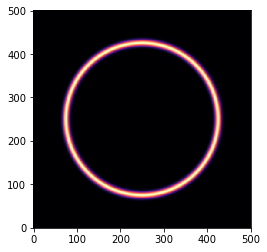

In [61]:
l_amp = 1.75   # Einstein radius
l_xcen = 0 # x position of center
l_ycen = 0  # y position of center
# l_axrat = 1.0 # minor-to-major axis ratio
# l_pa = 0.0    # major-axis position angle (degrees) c.c.w. from x axis
lpar = n.asarray([l_amp, l_xcen, l_ycen])

# Compute the lensing potential gradients:
##(xg, yg) = ldf.sie_grad(x, y, lpar)
(xg, yg) = sie_grad(x, y, lpar)

# Evaluate lensed Gaussian image:
##g_lensimage = ldf.gauss_2d(x-xg, y-yg, gpar)
g_lensimage = gauss_2d(x-xg, y-yg, gpar)

# Have a look:
f = p.imshow(g_lensimage, **myargs)

In [ ]:
# #
# # lensdemo_script.py
# #
# # A script to allow simple explortation of gravitational lensing
# # of extended objects (i.e., galaxies) by the gravity of a singular
# # isothermal ellipsoid (SIE) potential.
# #
# # This script is meant to be used as a cut-and-paste guide to an interactive
# # python2.5 command-line session, and is not necessarily to be run in
# # unmodified form from end to end.
# #
# # Requires numpy and matplotlib, as well as the suporting file "lensdemo_funcs.py"
# #
# # Copyright 2009 by Adam S. Bolton
# # Creative Commons Attribution-Noncommercial-ShareAlike 3.0 license applies:
# # http://creativecommons.org/licenses/by-nc-sa/3.0/
# # All redistributions, modified or otherwise, must include this
# # original copyright notice, licensing statement, and disclaimer.
# # DISCLAIMER: ABSOLUTELY NO WARRANTY EXPRESS OR IMPLIED.
# # AUTHOR ASSUMES NO LIABILITY IN CONNECTION WITH THIS COMPUTER CODE.
# #

# # Import the necessary packages
# import numpy as n
# import matplotlib as m
# # The following 2 lines are necessary to make the
# # GUI work right, at least for me. YMMV!
# m.use('TkAgg')
# m.interactive(True)
# from matplotlib import pyplot as p
# from matplotlib import cm
# ##import lensdemo_funcs as ldf

# # Package some image display preferences in a dictionary object, for use below:
# myargs = {'interpolation': 'nearest', 'origin': 'lower', 'cmap': cm.magma}
# #myargs = {'interpolation': 'nearest', 'origin': 'lower', 'cmap': cm.gray}

# # Make some x and y coordinate images:
# nx = 501
# ny = 501
# xhilo = [-2.5, 2.5]
# yhilo = [-2.5, 2.5]
# x = (xhilo[1] - xhilo[0]) * n.outer(n.ones(ny), n.arange(nx)) / float(nx-1) + xhilo[0]
# y = (yhilo[1] - yhilo[0]) * n.outer(n.arange(ny), n.ones(nx)) / float(ny-1) + yhilo[0]

# # Set some Gaussian blob image parameters and pack them into an array:
# g_amp = 1.0   # peak brightness value
# g_sig = 0.05  # Gaussian "sigma" (i.e., size)
# g_xcen = 0.0  # x position of center
# g_ycen = 0.0  # y position of center
# g_axrat = 1.0 # minor-to-major axis ratio
# g_pa = 0.0    # major-axis position angle (degrees) c.c.w. from x axis
# gpar = n.asarray([g_amp, g_sig, g_xcen, g_ycen, g_axrat, g_pa])

# # Have a look at the un-lensed Gaussian image:
# ## g_image = ldf.gauss_2d(x, y, gpar)
# g_image = gauss_2d(x, y, gpar)
# f = p.imshow(g_image, **myargs)
# # IMPORTANT: Kill these imshow GUIs before redisplaying, or you will get bad memory leaks!
# # You can kill it with the "red button", or with the following command:
# p.close(f.get_figure().number)
# # Alternatively, if you do the following you will probably be OK redisplaying
# # without killing the GUI:
# f.axes.hold(False)

# # Set some SIE lens-model parameters and pack them into an array:
# l_amp = 1.5   # Einstein radius
# l_xcen = 0.0  # x position of center
# l_ycen = 0.0  # y position of center
# l_axrat = 1.0 # minor-to-major axis ratio
# l_pa = 0.0    # major-axis position angle (degrees) c.c.w. from x axis
# lpar = n.asarray([l_amp, l_xcen, l_ycen, l_axrat, l_pa])

# # Compute the lensing potential gradients:
# ##(xg, yg) = ldf.sie_grad(x, y, lpar)
# (xg, yg) = sie_grad(x, y, lpar)

# # Evaluate lensed Gaussian image:
# ##g_lensimage = ldf.gauss_2d(x-xg, y-yg, gpar)
# g_lensimage = gauss_2d(x-xg, y-yg, gpar)

# # Have a look:
# f = p.imshow(g_lensimage, **myargs)

# # If you can recall what the parameter place values mean,
# # the following lines are most efficient for exploration:
# gpar = n.asarray([1.0, 0.05, 0.0, 0.0, 1.0, 0.0])
# lpar = n.asarray([1.5, 0.0, 0.0, 1.0, 0.0])
# ##(xg, yg) = ldf.sie_grad(x, y, lpar)
# (xg, yg) = sie_grad(x, y, lpar)
# ##g_lensimage = ldf.gauss_2d(x-xg, y-yg, gpar)
# g_lensimage = gauss_2d(x-xg, y-yg, gpar)
# f = p.imshow(g_lensimage, **myargs)
# f.axes.hold(False)

# # The following lines will plot the un-lensed and lensed images side by side:
# gpar = n.asarray([1.0, 0.05, 0.0, 0.0, 1.0, 0.0])
# lpar = n.asarray([1.0, 0.0, 0.0, 1.0, 0.0])
# ##g_image = ldf.gauss_2d(x, y, gpar)
# ##(xg, yg) = ldf.sie_grad(x, y, lpar)
# ##g_lensimage = ldf.gauss_2d(x-xg, y-yg, gpar)
# g_image = gauss_2d(x, y, gpar)
# (xg, yg) = sie_grad(x, y, lpar)
# g_lensimage = gauss_2d(x-xg, y-yg, gpar)
# f = p.imshow(n.hstack((g_image, g_lensimage)), **myargs)


# # The following lines can be used to verify that the SIE potential gradient
# # function actually computes what is is supposed to compute!
# # Feel free to disregard...

# # Pick some arbitrary lens parameters:
# lpar = n.asarray([1.11, -0.23, 0.59, 0.72, 33.3])
# # Compute the gradients:
# ##(xg, yg) = ldf.sie_grad(x, y, lpar)
# (xg, yg) = sie_grad(x, y, lpar)
# # Compute convergence as half the Laplacian of the potential from the gradients:
# kappa_g = 0.5 * ( (xg[1:-1,2:] - xg[1:-1,0:-2]) / (x[1:-1,2:] - x[1:-1,0:-2]) +
#                   (yg[2:,1:-1] - yg[0:-2,1:-1]) / (y[2:,1:-1] - y[0:-2,1:-1]))
# # Compute the expected analytic convergence for these lens parameters:
# ##(xn, yn) = ldf.xy_rotate(x, y, lpar[1], lpar[2], lpar[4])
# (xn, yn) = xy_rotate(x, y, lpar[1], lpar[2], lpar[4])
# kappa_a = 0.5 * lpar[0] / n.sqrt(lpar[3]*xn[1:-1,1:-1]**2 + yn[1:-1,1:-1]**2 / lpar[3])

# f = p.imshow(n.hstack((n.log(kappa_g), n.log(kappa_a), n.log(kappa_g) - n.log(kappa_a))),
#              vmax=n.log(kappa_g).max(), vmin=n.log(kappa_g).min(), **myargs)
# # OK, looks good!  Some disagreement in the center, which is to be expected.

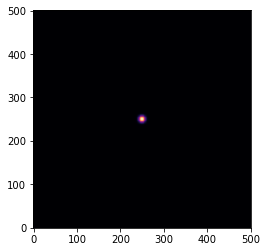

In [60]:
# Import the necessary packages
import numpy as n
import matplotlib as m
# The following 2 lines are necessary to make the
# GUI work right, at least for me. YMMV!
# m.use('TkAgg')
# m.interactive(True)

from matplotlib import pyplot as p
from matplotlib import cm
##import lensdemo_funcs as ldf

# Package some image display preferences in a dictionary object, for use below:
myargs = {'interpolation': 'nearest', 'origin': 'lower', 'cmap': cm.magma}
#myargs = {'interpolation': 'nearest', 'origin': 'lower', 'cmap': cm.gray}

# Make some x and y coordinate images:
nx = 501
ny = 501
xhilo = [-2.5, 2.5]
yhilo = [-2.5, 2.5]
x = (xhilo[1] - xhilo[0]) * n.outer(n.ones(ny), n.arange(nx)) / float(nx-1) + xhilo[0]
y = (yhilo[1] - yhilo[0]) * n.outer(n.arange(ny), n.ones(nx)) / float(ny-1) + yhilo[0]

# Set some Gaussian blob image parameters and pack them into an array:
g_amp = 1.0   # peak brightness value
g_sig = 0.05  # Gaussian "sigma" (i.e., size)
g_xcen = 0.0  # x position of center
g_ycen = 0.0  # y position of center
g_axrat = 1.0 # minor-to-major axis ratio
g_pa = 0.0    # major-axis position angle (degrees) c.c.w. from x axis
gpar = n.asarray([g_amp, g_sig, g_xcen, g_ycen, g_axrat, g_pa])

# Have a look at the un-lensed Gaussian image:
## g_image = ldf.gauss_2d(x, y, gpar)
g_image = gauss_2d(x, y, gpar)
f = p.imshow(g_image, **myargs)

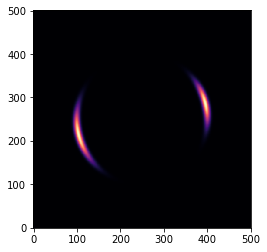

In [27]:
l_amp = 1.5   # Einstein radius
l_xcen = 0.2 # x position of center
l_ycen = 0.05  # y position of center
l_axrat = 1.0 # minor-to-major axis ratio
l_pa = 0.0    # major-axis position angle (degrees) c.c.w. from x axis
lpar = n.asarray([l_amp, l_xcen, l_ycen])

# Compute the lensing potential gradients:
##(xg, yg) = ldf.sie_grad(x, y, lpar)
(xg, yg) = sie_grad(x, y, lpar)

# Evaluate lensed Gaussian image:
##g_lensimage = ldf.gauss_2d(x-xg, y-yg, gpar)
g_lensimage = gauss_2d(x-xg, y-yg, gpar)

# Have a look:
f = p.imshow(g_lensimage, **myargs)


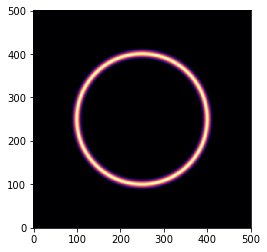

In [5]:
gpar = n.asarray([1.0, 0.05, 0.0, 0.0, 1.0, 0.0])
lpar = n.asarray([1.5, 0.0, 0.0, 1.0, 0.0])
##(xg, yg) = ldf.sie_grad(x, y, lpar)
(xg, yg) = sie_grad(x, y, lpar)
##g_lensimage = ldf.gauss_2d(x-xg, y-yg, gpar)
g_lensimage = gauss_2d(x-xg, y-yg, gpar)
f = p.imshow(g_lensimage, **myargs)

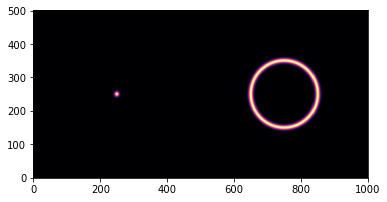

In [6]:
gpar = n.asarray([1.0, 0.05, 0.0, 0.0, 1.0, 0.0])
lpar = n.asarray([1.0, 0.0, 0.0, 1.0, 0.0])
##g_image = ldf.gauss_2d(x, y, gpar)
##(xg, yg) = ldf.sie_grad(x, y, lpar)
##g_lensimage = ldf.gauss_2d(x-xg, y-yg, gpar)
g_image = gauss_2d(x, y, gpar)
(xg, yg) = sie_grad(x, y, lpar)
g_lensimage = gauss_2d(x-xg, y-yg, gpar)
f = p.imshow(n.hstack((g_image, g_lensimage)), **myargs)

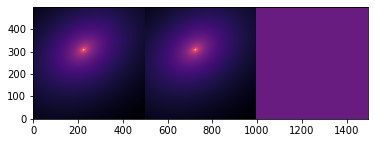

In [7]:
# The following lines can be used to verify that the SIE potential gradient
# function actually computes what is is supposed to compute!
# Feel free to disregard...

# Pick some arbitrary lens parameters:
lpar = n.asarray([1.11, -0.23, 0.59, 0.72, 33.3])
# Compute the gradients:
##(xg, yg) = ldf.sie_grad(x, y, lpar)
(xg, yg) = sie_grad(x, y, lpar)
# Compute convergence as half the Laplacian of the potential from the gradients:
kappa_g = 0.5 * ( (xg[1:-1,2:] - xg[1:-1,0:-2]) / (x[1:-1,2:] - x[1:-1,0:-2]) +
                  (yg[2:,1:-1] - yg[0:-2,1:-1]) / (y[2:,1:-1] - y[0:-2,1:-1]))
# Compute the expected analytic convergence for these lens parameters:
##(xn, yn) = ldf.xy_rotate(x, y, lpar[1], lpar[2], lpar[4])
(xn, yn) = xy_rotate(x, y, lpar[1], lpar[2], lpar[4])
kappa_a = 0.5 * lpar[0] / n.sqrt(lpar[3]*xn[1:-1,1:-1]**2 + yn[1:-1,1:-1]**2 / lpar[3])

f = p.imshow(n.hstack((n.log(kappa_g), n.log(kappa_a), n.log(kappa_g) - n.log(kappa_a))),
             vmax=n.log(kappa_g).max(), vmin=n.log(kappa_g).min(), **myargs)
# OK, looks good!  Some disagreement in the center, which is to be expected.